# Solar Orbiter
This example demonstrates a ballistic model inspired by the solar orbiter mission.

In [1]:
# Pykep imports
from pykep.trajopt import mga_1dsm, launchers
from pykep.planet import jpl_lp
from pykep import epoch
from pykep.core import lambert_problem, propagate_lagrangian, fb_prop
from pykep import DAY2SEC, DAY2YEAR, AU, RAD2DEG, ic2par
from pykep.trajopt.gym._solar_orbiter import _solar_orbiter_udp

# Other imports
import numpy as np
from numpy.linalg import norm
from numpy import sign
from math import acos, asin, cos, exp, log, pi, sin
import matplotlib.pyplot as plt
from copy import deepcopy
import pygmo
import time

In [2]:
#%matplotlib notebook

In [3]:
# define search window
tmin = epoch(time.time() / (24*3600) - 30*365 -7 + 2/24 - 2*365)
tmax = epoch(time.time() / (24*3600) - 30*365 -7 + 2/24 + 2*365)

In [4]:
solar_orbiter = _solar_orbiter_udp([tmin, tmax])

In [5]:
# Include delta v, mass and sun distance constraints
prob = pygmo.unconstrain(pygmo.problem(solar_orbiter),method="weighted",weights=[1.0, 10.0, 100, 100])

In [6]:
# define problem and algorithm
pop = pygmo.population(prob=prob, size=50)
alg = pygmo.algorithm(pygmo.sade(memory=True,gen=1))

In [7]:
# run evolution
for i in range(3000):
    pop = alg.evolve(pop)
    print(i, pop.champion_f, solar_orbiter.fitness(pop.champion_x))

0 [41416.06869866] [3.9390389086118995, 23413.129659752798, 1799.9, -0.3148155429926517, -0.19999999999999996]
1 [41416.06869866] [3.9390389086118995, 23413.129659752798, 1799.9, -0.3148155429926517, -0.19999999999999996]
2 [36473.64943228] [4.417358869316377, 18470.23207340909, 1799.9, -0.4426212338485074, -0.19999999999999996]
3 [36473.64943228] [4.417358869316377, 18470.23207340909, 1799.9, -0.4426212338485074, -0.19999999999999996]
4 [36473.64943228] [4.417358869316377, 18470.23207340909, 1799.9, -0.4426212338485074, -0.19999999999999996]
5 [36473.64943228] [4.417358869316377, 18470.23207340909, 1799.9, -0.4426212338485074, -0.19999999999999996]
6 [34069.67806902] [4.351803169870452, 16066.326265845695, 1799.9, -0.43032256346011233, -0.19999999999999996]
7 [34069.66762756] [4.341361712676743, 16066.326265845695, 1799.9, -0.42457263610262874, -0.19999999999999996]
8 [34069.66762756] [4.341361712676743, 16066.326265845695, 1799.9, -0.42457263610262874, -0.19999999999999996]
9 [3989.4

69 [3989.41255746] [4.393477665353113, 3985.0190797990626, -2927.9230009893317, -0.4415560842128605, -0.19999999999999996]
70 [3773.24896019] [4.347648977713575, 3768.901311214384, -2927.9230009893317, -0.42852680030677803, -0.19999999999999996]
71 [1702.59758472] [4.362118117021366, 1698.235466598444, -2927.9230009893317, -0.43092513926906606, -0.19999999999999996]
72 [1702.59758472] [4.362118117021366, 1698.235466598444, -2927.9230009893317, -0.43092513926906606, -0.19999999999999996]
73 [1702.59758472] [4.362118117021366, 1698.235466598444, -2927.9230009893317, -0.43092513926906606, -0.19999999999999996]
74 [1702.59758472] [4.362118117021366, 1698.235466598444, -2927.9230009893317, -0.43092513926906606, -0.19999999999999996]
75 [1702.59758472] [4.362118117021366, 1698.235466598444, -2927.9230009893317, -0.43092513926906606, -0.19999999999999996]
76 [1702.59758472] [4.362118117021366, 1698.235466598444, -2927.9230009893317, -0.43092513926906606, -0.19999999999999996]
77 [1702.5975847

137 [1595.40484867] [4.240894209458899, 1591.163954455782, -2927.9230009893317, -0.41350645614130865, -0.19999999999999996]
138 [1595.40484867] [4.240894209458899, 1591.163954455782, -2927.9230009893317, -0.41350645614130865, -0.19999999999999996]
139 [1595.40484867] [4.240894209458899, 1591.163954455782, -2927.9230009893317, -0.41350645614130865, -0.19999999999999996]
140 [1595.40484867] [4.240894209458899, 1591.163954455782, -2927.9230009893317, -0.41350645614130865, -0.19999999999999996]
141 [1595.40484867] [4.240894209458899, 1591.163954455782, -2927.9230009893317, -0.41350645614130865, -0.19999999999999996]
142 [1595.40484867] [4.240894209458899, 1591.163954455782, -2927.9230009893317, -0.41350645614130865, -0.19999999999999996]
143 [1595.40484867] [4.240894209458899, 1591.163954455782, -2927.9230009893317, -0.41350645614130865, -0.19999999999999996]
144 [1595.40484867] [4.240894209458899, 1591.163954455782, -2927.9230009893317, -0.41350645614130865, -0.19999999999999996]
145 [159

207 [422.30115841] [2.846801284901625, 419.45435712804647, -520.0118099419219, -0.04695941040724111, -0.19999999999999996]
208 [422.30115841] [2.846801284901625, 419.45435712804647, -520.0118099419219, -0.04695941040724111, -0.19999999999999996]
209 [422.30115841] [2.846801284901625, 419.45435712804647, -520.0118099419219, -0.04695941040724111, -0.19999999999999996]
210 [422.30115841] [2.846801284901625, 419.45435712804647, -520.0118099419219, -0.04695941040724111, -0.19999999999999996]
211 [422.30115841] [2.846801284901625, 419.45435712804647, -520.0118099419219, -0.04695941040724111, -0.19999999999999996]
212 [422.30115841] [2.846801284901625, 419.45435712804647, -520.0118099419219, -0.04695941040724111, -0.19999999999999996]
213 [422.30115841] [2.846801284901625, 419.45435712804647, -520.0118099419219, -0.04695941040724111, -0.19999999999999996]
214 [422.30115841] [2.846801284901625, 419.45435712804647, -520.0118099419219, -0.04695941040724111, -0.19999999999999996]
215 [422.3011584

279 [422.26408262] [2.809725487749632, 419.45435712804647, -520.0118099419219, -0.03825811580753058, -0.19999999999999996]
280 [422.26408262] [2.809725487749632, 419.45435712804647, -520.0118099419219, -0.03825811580753058, -0.19999999999999996]
281 [422.26408262] [2.809725487749632, 419.45435712804647, -520.0118099419219, -0.03825811580753058, -0.19999999999999996]
282 [422.26408262] [2.809725487749632, 419.45435712804647, -520.0118099419219, -0.03825811580753058, -0.19999999999999996]
283 [422.26408262] [2.809725487749632, 419.45435712804647, -520.0118099419219, -0.03825811580753058, -0.19999999999999996]
284 [422.26408262] [2.809725487749632, 419.45435712804647, -520.0118099419219, -0.03825811580753058, -0.19999999999999996]
285 [422.26408262] [2.809725487749632, 419.45435712804647, -520.0118099419219, -0.03825811580753058, -0.19999999999999996]
286 [422.26408262] [2.809725487749632, 419.45435712804647, -520.0118099419219, -0.03825811580753058, -0.19999999999999996]
287 [422.2640826

352 [416.96802407] [2.7832290905009534, 414.1847949822459, -520.0118099419219, -0.032217841728827856, -0.19999999999999996]
353 [359.00670001] [4.367930904048977, 354.6387691013206, -1141.8405974999318, -0.4348500909204823, -0.19999999999999996]
354 [359.00670001] [4.367930904048977, 354.6387691013206, -1141.8405974999318, -0.4348500909204823, -0.19999999999999996]
355 [359.00585813] [4.367089028809634, 354.6387691013206, -1141.8405974999318, -0.4339488933376797, -0.19999999999999996]
356 [359.00585813] [4.367089028809634, 354.6387691013206, -1141.8405974999318, -0.4339488933376797, -0.19999999999999996]
357 [359.00585813] [4.367089028809634, 354.6387691013206, -1141.8405974999318, -0.4339488933376797, -0.19999999999999996]
358 [359.00585813] [4.367089028809634, 354.6387691013206, -1141.8405974999318, -0.4339488933376797, -0.19999999999999996]
359 [359.00585813] [4.367089028809634, 354.6387691013206, -1141.8405974999318, -0.4339488933376797, -0.19999999999999996]
360 [359.00585813] [4.

422 [193.87084526] [2.8271827500131685, 191.04366251473493, -520.0118099419219, -0.0405943670309713, -0.19999999999999996]
423 [193.87084526] [2.8271827500131685, 191.04366251473493, -520.0118099419219, -0.0405943670309713, -0.19999999999999996]
424 [193.87084526] [2.8271827500131685, 191.04366251473493, -520.0118099419219, -0.0405943670309713, -0.19999999999999996]
425 [193.87084526] [2.8271827500131685, 191.04366251473493, -520.0118099419219, -0.0405943670309713, -0.19999999999999996]
426 [193.87084526] [2.8271827500131685, 191.04366251473493, -520.0118099419219, -0.0405943670309713, -0.19999999999999996]
427 [193.87084526] [2.8271827500131685, 191.04366251473493, -520.0118099419219, -0.0405943670309713, -0.19999999999999996]
428 [193.87084526] [2.8271827500131685, 191.04366251473493, -520.0118099419219, -0.0405943670309713, -0.19999999999999996]
429 [193.87084526] [2.8271827500131685, 191.04366251473493, -520.0118099419219, -0.0405943670309713, -0.19999999999999996]
430 [193.8708452

489 [122.49474249] [2.874319224392954, 119.62042326913433, -140.19208701755792, -0.04997227389341902, -0.19999999999999996]
490 [122.49474249] [2.874319224392954, 119.62042326913433, -140.19208701755792, -0.04997227389341902, -0.19999999999999996]
491 [122.49474249] [2.874319224392954, 119.62042326913433, -140.19208701755792, -0.04997227389341902, -0.19999999999999996]
492 [122.49474249] [2.874319224392954, 119.62042326913433, -140.19208701755792, -0.04997227389341902, -0.19999999999999996]
493 [122.49474249] [2.874319224392954, 119.62042326913433, -140.19208701755792, -0.04997227389341902, -0.19999999999999996]
494 [122.49474249] [2.874319224392954, 119.62042326913433, -140.19208701755792, -0.04997227389341902, -0.19999999999999996]
495 [122.49474249] [2.874319224392954, 119.62042326913433, -140.19208701755792, -0.04997227389341902, -0.19999999999999996]
496 [102.08742443] [2.815211811684133, 99.2722126155677, -1255.4410132863813, -0.04027987630083668, -0.19999999999999996]
497 [102.0

560 [102.08742443] [2.815211811684133, 99.2722126155677, -1255.4410132863813, -0.04027987630083668, -0.19999999999999996]
561 [63.91093634] [3.537071514149474, 60.37386482594138, -140.19208701755792, -0.2543446384639624, -0.19999999999999996]
562 [63.91093634] [3.537071514149474, 60.37386482594138, -140.19208701755792, -0.2543446384639624, -0.19999999999999996]
563 [63.91093634] [3.537071514149474, 60.37386482594138, -140.19208701755792, -0.2543446384639624, -0.19999999999999996]
564 [63.91093634] [3.537071514149474, 60.37386482594138, -140.19208701755792, -0.2543446384639624, -0.19999999999999996]
565 [63.91093634] [3.537071514149474, 60.37386482594138, -140.19208701755792, -0.2543446384639624, -0.19999999999999996]
566 [63.9109337] [3.5370688694470367, 60.37386482594138, -140.19208701755792, -0.2543429166197134, -0.19999999999999996]
567 [63.9109337] [3.5370688694470367, 60.37386482594138, -140.19208701755792, -0.2543429166197134, -0.19999999999999996]
568 [63.9109337] [3.53706886944

628 [33.41268582] [2.835684095505432, 30.577001722631394, -66.1058594330375, -0.05049241442459956, -0.19999999999999996]
629 [33.41268582] [2.835684095505432, 30.577001722631394, -66.1058594330375, -0.05049241442459956, -0.19999999999999996]
630 [33.41163929] [2.834637565487628, 30.577001722631394, -66.1058594330375, -0.05025946055861952, -0.19999999999999996]
631 [33.41163929] [2.834637565487628, 30.577001722631394, -66.1058594330375, -0.05025946055861952, -0.19999999999999996]
632 [33.41163929] [2.834637565487628, 30.577001722631394, -66.1058594330375, -0.05025946055861952, -0.19999999999999996]
633 [33.41163929] [2.834637565487628, 30.577001722631394, -66.1058594330375, -0.05025946055861952, -0.19999999999999996]
634 [33.41163929] [2.834637565487628, 30.577001722631394, -66.1058594330375, -0.05025946055861952, -0.19999999999999996]
635 [33.41163929] [2.834637565487628, 30.577001722631394, -66.1058594330375, -0.05025946055861952, -0.19999999999999996]
636 [33.41163929] [2.83463756548

699 [33.4116126] [2.8346108808576296, 30.577001722631394, -66.1058594330375, -0.05025352126289884, -0.19999999999999996]
700 [33.4116126] [2.8346108808576296, 30.577001722631394, -66.1058594330375, -0.05025352126289884, -0.19999999999999996]
701 [33.4116126] [2.8346108808576296, 30.577001722631394, -66.1058594330375, -0.05025352126289884, -0.19999999999999996]
702 [33.4116126] [2.8346108808576296, 30.577001722631394, -66.1058594330375, -0.05025352126289884, -0.19999999999999996]
703 [33.4116126] [2.8346108808576296, 30.577001722631394, -66.1058594330375, -0.05025352126289884, -0.19999999999999996]
704 [33.4116126] [2.8346108808576296, 30.577001722631394, -66.1058594330375, -0.05025352126289884, -0.19999999999999996]
705 [33.4116126] [2.8346108808576296, 30.577001722631394, -66.1058594330375, -0.05025352126289884, -0.19999999999999996]
706 [33.4116126] [2.8346108808576296, 30.577001722631394, -66.1058594330375, -0.05025352126289884, -0.19999999999999996]
707 [33.41158584] [2.83458411488

767 [23.29835585] [2.8144330273767286, 20.483922824669207, -191.9301280124514, -0.044864087074832526, -0.19999999999999996]
768 [23.29835585] [2.8144330273767286, 20.483922824669207, -191.9301280124514, -0.044864087074832526, -0.19999999999999996]
769 [23.29835585] [2.8144330273767286, 20.483922824669207, -191.9301280124514, -0.044864087074832526, -0.19999999999999996]
770 [23.29835585] [2.8144330273767286, 20.483922824669207, -191.9301280124514, -0.044864087074832526, -0.19999999999999996]
771 [23.29835585] [2.8144330273767286, 20.483922824669207, -191.9301280124514, -0.044864087074832526, -0.19999999999999996]
772 [23.29835585] [2.8144330273767286, 20.483922824669207, -191.9301280124514, -0.044864087074832526, -0.19999999999999996]
773 [23.29835585] [2.8144330273767286, 20.483922824669207, -191.9301280124514, -0.044864087074832526, -0.19999999999999996]
774 [23.29835585] [2.8144330273767286, 20.483922824669207, -191.9301280124514, -0.044864087074832526, -0.19999999999999996]
775 [23.

839 [23.2983543] [2.814431476442296, 20.483922824669207, -191.9301280124514, -0.044863740016134246, -0.19999999999999996]
840 [23.2983543] [2.814431476442296, 20.483922824669207, -191.9301280124514, -0.044863740016134246, -0.19999999999999996]
841 [23.2983543] [2.814431476442296, 20.483922824669207, -191.9301280124514, -0.044863740016134246, -0.19999999999999996]
842 [23.2983543] [2.814431476442296, 20.483922824669207, -191.9301280124514, -0.044863740016134246, -0.19999999999999996]
843 [23.2983543] [2.814431476442296, 20.483922824669207, -191.9301280124514, -0.044863740016134246, -0.19999999999999996]
844 [23.2983543] [2.814431476442296, 20.483922824669207, -191.9301280124514, -0.044863740016134246, -0.19999999999999996]
845 [23.2983543] [2.814431476442296, 20.483922824669207, -191.9301280124514, -0.044863740016134246, -0.19999999999999996]
846 [23.2983543] [2.814431476442296, 20.483922824669207, -191.9301280124514, -0.044863740016134246, -0.19999999999999996]
847 [23.2983543] [2.8144

909 [2.8955149] [2.8955149001504594, -0.40207094111428887, -214.63129274588232, -0.08432853213319391, -0.19999999999999996]
910 [2.8955149] [2.8955149001504594, -0.40207094111428887, -214.63129274588232, -0.08432853213319391, -0.19999999999999996]
911 [2.8955149] [2.8955149001504594, -0.40207094111428887, -214.63129274588232, -0.08432853213319391, -0.19999999999999996]
912 [2.8955149] [2.8955149001504594, -0.40207094111428887, -214.63129274588232, -0.08432853213319391, -0.19999999999999996]
913 [2.8955149] [2.8955149001504594, -0.40207094111428887, -214.63129274588232, -0.08432853213319391, -0.19999999999999996]
914 [2.8955149] [2.8955149001504594, -0.40207094111428887, -214.63129274588232, -0.08432853213319391, -0.19999999999999996]
915 [2.8955149] [2.8955149001504594, -0.40207094111428887, -214.63129274588232, -0.08432853213319391, -0.19999999999999996]
916 [2.8955149] [2.8955149001504594, -0.40207094111428887, -214.63129274588232, -0.08432853213319391, -0.19999999999999996]
917 [2.8

976 [2.81135841] [2.811358414613811, -0.40207094111428887, -214.63129274588232, -0.04413412065485672, -0.19999999999999996]
977 [2.81135841] [2.811358414613811, -0.40207094111428887, -214.63129274588232, -0.04413412065485672, -0.19999999999999996]
978 [2.81135841] [2.811358414613811, -0.40207094111428887, -214.63129274588232, -0.04413412065485672, -0.19999999999999996]
979 [2.81135841] [2.811358414613811, -0.40207094111428887, -214.63129274588232, -0.04413412065485672, -0.19999999999999996]
980 [2.81135841] [2.811358414613811, -0.40207094111428887, -214.63129274588232, -0.04413412065485672, -0.19999999999999996]
981 [2.81135841] [2.811358414613811, -0.40207094111428887, -214.63129274588232, -0.04413412065485672, -0.19999999999999996]
982 [2.81135841] [2.811358414613811, -0.40207094111428887, -214.63129274588232, -0.04413412065485672, -0.19999999999999996]
983 [2.81135841] [2.811358414613811, -0.40207094111428887, -214.63129274588232, -0.04413412065485672, -0.19999999999999996]
984 [2.8

1044 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]
1045 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]
1046 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]
1047 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]
1048 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]
1049 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]
1050 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]
1051 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]


1118 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]
1119 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]
1120 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]
1121 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]
1122 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]
1123 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]
1124 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]
1125 [2.81135835] [2.8113583549215884, -0.40207094111428887, -214.63129274588232, -0.0441341072894092, -0.19999999999999996]


1188 [2.81123252] [2.81123251734061, -0.40207094111428887, -214.63129274588232, -0.044932838118765805, -0.19999999999999996]
1189 [2.81123252] [2.81123251734061, -0.40207094111428887, -214.63129274588232, -0.044932838118765805, -0.19999999999999996]
1190 [2.81123252] [2.81123251734061, -0.40207094111428887, -214.63129274588232, -0.044932838118765805, -0.19999999999999996]
1191 [2.81123252] [2.81123251734061, -0.40207094111428887, -214.63129274588232, -0.044932838118765805, -0.19999999999999996]
1192 [2.81123252] [2.81123251734061, -0.40207094111428887, -214.63129274588232, -0.044932838118765805, -0.19999999999999996]
1193 [2.81123252] [2.81123251734061, -0.40207094111428887, -214.63129274588232, -0.044932838118765805, -0.19999999999999996]
1194 [2.81123252] [2.81123251734061, -0.40207094111428887, -214.63129274588232, -0.044932838118765805, -0.19999999999999996]
1195 [2.81123252] [2.81123251734061, -0.40207094111428887, -214.63129274588232, -0.044932838118765805, -0.19999999999999996]


1256 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1257 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1258 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1259 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1260 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1261 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1262 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1263 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1264 [2.

1325 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1326 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1327 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1328 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1329 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1330 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1331 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1332 [2.8109122] [2.8109122023861484, -3.7612905955411406, -214.63129274588232, -0.04484019855349264, -0.19999999999999996]
1333 [2.

1394 [2.8109122] [2.8109122023823057, -3.7612905955411406, -214.63129274588232, -0.04484019855263832, -0.19999999999999996]
1395 [2.8109122] [2.8109122023823057, -3.7612905955411406, -214.63129274588232, -0.04484019855263832, -0.19999999999999996]
1396 [2.8109122] [2.8109122023823057, -3.7612905955411406, -214.63129274588232, -0.04484019855263832, -0.19999999999999996]
1397 [2.8109122] [2.8109122023823057, -3.7612905955411406, -214.63129274588232, -0.04484019855263832, -0.19999999999999996]
1398 [2.8109122] [2.8109122023823057, -3.7612905955411406, -214.63129274588232, -0.04484019855263832, -0.19999999999999996]
1399 [2.8109122] [2.8109122023823057, -3.7612905955411406, -214.63129274588232, -0.04484019855263832, -0.19999999999999996]
1400 [2.8109122] [2.8109122023823057, -3.7612905955411406, -214.63129274588232, -0.04484019855263832, -0.19999999999999996]
1401 [2.8109122] [2.8109122023823057, -3.7612905955411406, -214.63129274588232, -0.04484019855263832, -0.19999999999999996]
1402 [2.

1464 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1465 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1466 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1467 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1468 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1469 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1470 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1471 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1472 [2.79406081

1531 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1532 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1533 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1534 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1535 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1536 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1537 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1538 [2.79406081] [2.794060808193879, -1.2028979047609027, -1240.4369717570771, -0.0406750827383866, -0.19999999999999996]
1539 [2.79406081

1602 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1603 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1604 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1605 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1606 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1607 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1608 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1609 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999

1669 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1670 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1671 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1672 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1673 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1674 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1675 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1676 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999

1741 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1742 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1743 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1744 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1745 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1746 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1747 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1748 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999

1811 [2.79406081] [2.7940608081938736, -1.2028979047609027, -1240.4369717570771, -0.040675082738385326, -0.19999999999999996]
1812 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1813 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1814 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1815 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1816 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1817 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1818 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1819 [

1878 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1879 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1880 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1881 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1882 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1883 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1884 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1885 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1886 [2.

1951 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1952 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1953 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1954 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1955 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1956 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1957 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1958 [2.79379729] [2.7937972900561547, -3.17488240811781, -1240.4369717570771, -0.040604748622545095, -0.19999999999999996]
1959 [2.

2020 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2021 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2022 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2023 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2024 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2025 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2026 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2027 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2028 [2.79262161

2091 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2092 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2093 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2094 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2095 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2096 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2097 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2098 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2099 [2.79262161

2162 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2163 [2.79262161] [2.792621608673891, -2.7407980446396323, -1239.2351440558145, -0.0404636454267448, -0.19999999999999996]
2164 [2.79260772] [2.79260772443285, -2.7407980446396323, -1239.2351440558145, -0.040224641930950766, -0.19999999999999996]
2165 [2.79260772] [2.79260772443285, -2.7407980446396323, -1239.2351440558145, -0.040224641930950766, -0.19999999999999996]
2166 [2.79260772] [2.79260772443285, -2.7407980446396323, -1239.2351440558145, -0.040224641930950766, -0.19999999999999996]
2167 [2.79232494] [2.792324938812163, -0.4568082835385212, -1239.2351440558145, -0.04014903076408832, -0.19999999999999996]
2168 [2.79232494] [2.792324938812163, -0.4568082835385212, -1239.2351440558145, -0.04014903076408832, -0.19999999999999996]
2169 [2.79232494] [2.792324938812163, -0.4568082835385212, -1239.2351440558145, -0.04014903076408832, -0.19999999999999996]
2170 [2.79

2230 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2231 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2232 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2233 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2234 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2235 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2236 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2237 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2238 [2.

2298 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2299 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2300 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2301 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2302 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2303 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2304 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2305 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2306 [2.

2366 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2367 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2368 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2369 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2370 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2371 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2372 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2373 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2374 [2.

2436 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2437 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2438 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2439 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2440 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2441 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2442 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2443 [2.79232494] [2.792324938812161, -0.4568082835385212, -1239.2351440558145, -0.04014903076408799, -0.19999999999999996]
2444 [2.

2506 [2.79226564] [2.7922656411487674, -4.28862706858672, -1238.1628620397187, -0.040112382376935485, -0.19999999999999996]
2507 [2.79226564] [2.7922656411487674, -4.28862706858672, -1238.1628620397187, -0.040112382376935485, -0.19999999999999996]
2508 [2.79226564] [2.7922656411487674, -4.28862706858672, -1238.1628620397187, -0.040112382376935485, -0.19999999999999996]
2509 [2.79226564] [2.7922656411487674, -4.28862706858672, -1238.1628620397187, -0.040112382376935485, -0.19999999999999996]
2510 [2.79226564] [2.7922656411487674, -4.28862706858672, -1238.1628620397187, -0.040112382376935485, -0.19999999999999996]
2511 [2.79226564] [2.7922656411487674, -4.28862706858672, -1238.1628620397187, -0.040112382376935485, -0.19999999999999996]
2512 [2.79226564] [2.7922656411487674, -4.28862706858672, -1238.1628620397187, -0.040112382376935485, -0.19999999999999996]
2513 [2.79226564] [2.7922656411487674, -4.28862706858672, -1238.1628620397187, -0.040112382376935485, -0.19999999999999996]
2514 [2.

2580 [2.7894125] [2.789412501413202, -0.8913572516448767, -281.23374308270195, -0.03894481913563158, -0.1956545647332968]
2581 [2.7894125] [2.789412501413202, -0.8913572516448767, -281.23374308270195, -0.03894481913563158, -0.1956545647332968]
2582 [2.7894125] [2.789412501413202, -0.8913572516448767, -281.23374308270195, -0.03894481913563158, -0.1956545647332968]
2583 [2.7894125] [2.789412501413202, -0.8913572516448767, -281.23374308270195, -0.03894481913563158, -0.1956545647332968]
2584 [2.7894125] [2.789412501413202, -0.8913572516448767, -281.23374308270195, -0.03894481913563158, -0.1956545647332968]
2585 [2.7894125] [2.789412501413202, -0.8913572516448767, -281.23374308270195, -0.03894481913563158, -0.1956545647332968]
2586 [2.7894125] [2.789412501413202, -0.8913572516448767, -281.23374308270195, -0.03894481913563158, -0.1956545647332968]
2587 [2.7894125] [2.789412501413202, -0.8913572516448767, -281.23374308270195, -0.03894481913563158, -0.1956545647332968]
2588 [2.7894125] [2.7894

2652 [2.78769163] [2.7876916307086654, -0.9410986188722745, -281.7454834377272, -0.03844072611990862, -0.19559414030523414]
2653 [2.78769163] [2.7876916307086654, -0.9410986188722745, -281.7454834377272, -0.03844072611990862, -0.19559414030523414]
2654 [2.78769163] [2.7876916307086654, -0.9410986188722745, -281.7454834377272, -0.03844072611990862, -0.19559414030523414]
2655 [2.78769163] [2.7876916307086654, -0.9410986188722745, -281.7454834377272, -0.03844072611990862, -0.19559414030523414]
2656 [2.78707745] [2.787077450092264, -0.7278980175788092, -295.1523169602524, -0.03819858253809849, -0.19578600098859655]
2657 [2.78707745] [2.787077450092264, -0.7278980175788092, -295.1523169602524, -0.03819858253809849, -0.19578600098859655]
2658 [2.78631062] [2.7863106198785896, -3.2379551946878564, -297.86977318174604, -0.03801024610789272, -0.19581819089687436]
2659 [2.78559742] [2.7855974194533184, -0.5685756526490877, -299.174924689627, -0.03787611656658618, -0.19582198176278776]
2660 [2.78

2719 [2.78335805] [2.783358047660978, -0.9034289195387828, -311.52161863193487, -0.0371944272881472, -0.1959367589229306]
2720 [2.78335805] [2.783358047660978, -0.9034289195387828, -311.52161863193487, -0.0371944272881472, -0.1959367589229306]
2721 [2.78335805] [2.783358047660978, -0.9034289195387828, -311.52161863193487, -0.0371944272881472, -0.1959367589229306]
2722 [2.78335805] [2.783358047660978, -0.9034289195387828, -311.52161863193487, -0.0371944272881472, -0.1959367589229306]
2723 [2.78335805] [2.783358047660978, -0.9034289195387828, -311.52161863193487, -0.0371944272881472, -0.1959367589229306]
2724 [2.78335805] [2.783358047660978, -0.9034289195387828, -311.52161863193487, -0.0371944272881472, -0.1959367589229306]
2725 [2.78335805] [2.783358047660978, -0.9034289195387828, -311.52161863193487, -0.0371944272881472, -0.1959367589229306]
2726 [2.78335805] [2.783358047660978, -0.9034289195387828, -311.52161863193487, -0.0371944272881472, -0.1959367589229306]
2727 [2.78220131] [2.782

2788 [2.78098741] [2.7809874108093937, -2.427970648682276, -336.91395022167035, -0.03671735527467618, -0.1963087307860627]
2789 [2.78098741] [2.7809874108093937, -2.427970648682276, -336.91395022167035, -0.03671735527467618, -0.1963087307860627]
2790 [2.78098741] [2.7809874108093937, -2.427970648682276, -336.91395022167035, -0.03671735527467618, -0.1963087307860627]
2791 [2.77845889] [2.7784588862146227, -4.905090256867879, -381.47540392502106, -0.03599117789124612, -0.19691298769777998]
2792 [2.77845889] [2.7784588862146227, -4.905090256867879, -381.47540392502106, -0.03599117789124612, -0.19691298769777998]
2793 [2.77845889] [2.7784588862146227, -4.905090256867879, -381.47540392502106, -0.03599117789124612, -0.19691298769777998]
2794 [2.77845889] [2.7784588862146227, -4.905090256867879, -381.47540392502106, -0.03599117789124612, -0.19691298769777998]
2795 [2.77845889] [2.7784588862146227, -4.905090256867879, -381.47540392502106, -0.03599117789124612, -0.19691298769777998]
2796 [2.778

2858 [2.7737608] [2.773760800761007, -0.6978452978255518, -410.3852561573826, -0.03478831353914863, -0.19722898799704125]
2859 [2.77354575] [2.773545749348811, -1.376730364755531, -422.6659346816, -0.03475248398078329, -0.1973543972563403]
2860 [2.77354575] [2.77354574934881, -1.376730364755531, -422.6659346816, -0.03475248398078301, -0.1973543972563403]
2861 [2.77354575] [2.77354574934881, -1.376730364755531, -422.6659346816, -0.03475248398078301, -0.1973543972563403]
2862 [2.77354575] [2.77354574934881, -1.376730364755531, -422.6659346816, -0.03475248398078301, -0.1973543972563403]
2863 [2.77354575] [2.77354574934881, -1.376730364755531, -422.6659346816, -0.03475248398078301, -0.1973543972563403]
2864 [2.77354575] [2.77354574934881, -1.376730364755531, -422.6659346816, -0.03475248398078301, -0.1973543972563403]
2865 [2.77354575] [2.77354574934881, -1.376730364755531, -422.6659346816, -0.03475248398078301, -0.1973543972563403]
2866 [2.77354575] [2.77354574934881, -1.376730364755531, -

2933 [2.76897796] [2.768977955358135, -2.5398367145799057, -417.06788705094004, -0.0332708823379782, -0.19718630469481413]
2934 [2.76897796] [2.768977955358135, -2.5398367145799057, -417.06788705094004, -0.0332708823379782, -0.19718630469481413]
2935 [2.76897796] [2.768977955358135, -2.5398367145799057, -417.06788705094004, -0.0332708823379782, -0.19718630469481413]
2936 [2.76897796] [2.768977955358135, -2.5398367145799057, -417.06788705094004, -0.0332708823379782, -0.19718630469481413]
2937 [2.76897796] [2.768977955358135, -2.5398367145799057, -417.06788705094004, -0.0332708823379782, -0.19718630469481413]
2938 [2.76897796] [2.768977955358135, -2.5398367145799057, -417.06788705094004, -0.0332708823379782, -0.19718630469481413]
2939 [2.76897796] [2.768977955358135, -2.5398367145799057, -417.06788705094004, -0.0332708823379782, -0.19718630469481413]
2940 [2.76897796] [2.768977955358135, -2.5398367145799057, -417.06788705094004, -0.0332708823379782, -0.19718630469481413]
2941 [2.76897796

In [8]:
pop.champion_x

array([7.87008085e+03, 2.39983215e+02, 4.21253261e+02, 1.45956159e+02,
       1.58688405e+02, 1.80989897e+00, 1.05783212e+00])

In [9]:
solar_orbiter.fitness(pop.champion_x)

[2.7580705306783724,
 -1.3709938413085183,
 -621.2175586840949,
 -0.030744737505553676,
 -0.19999999999999996]

In [10]:
# start date
epoch(pop.champion_x[0])

2021-Jul-19 01:56:25.699937

In [11]:
# Inspect best result
solar_orbiter.pretty(pop.champion_x)

Multiple Gravity Assist (MGA) problem: 
Planet sequence:  ['earth', 'venus', 'venus', 'earth', 'venus']
Departure:  earth
	Epoch:  7870.080853008533  [mjd2000]
	Spacecraft velocity:  (26556.8910517055, 6548.840567930347, -1056.8179705770756) [m/s]
	Launch velocity:  [347.47984159383486, -6560.118572334344, -1056.1762551412676] [m/s]
Fly-by:  venus
	Epoch:  8110.06406796274  [mjd2000]
	DV:  0.2289761957472365 [m/s]
Fly-by:  venus
	Epoch:  8531.31732932006  [mjd2000]
	DV:  4.947484932709813 [m/s]
Fly-by:  earth
	Epoch:  8677.273488628913  [mjd2000]
	DV:  3.4525450302344325 [m/s]
Final Fly-by:  venus
	Epoch:  8835.961893889214  [mjd2000]
	Spacecraft velocity:  (34922.0395660297, 4354.125372900537, -84.27016626005718) [m/s]
	Beta:  1.8098989727681527
	r_p:  1.0578321216126902
Resulting Solar orbit:
Perihelion:  0.3107447375055537  AU
Aphelion:  0.8128657013169425  AU
Inclination:  3.1916468525974264  degrees
Time of flights:  [239.98321495 421.25326136 145.95615931 158.68840526] [days]


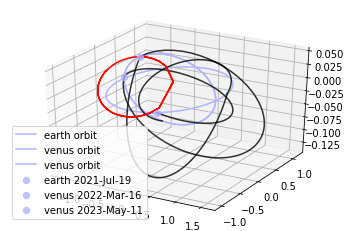

In [12]:
# Plot best result
solar_orbiter.plot(pop.champion_x)

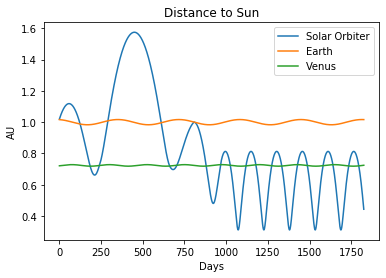

In [13]:
# Plot solar distance in AE
timeframe = range(1,5*365)
earth = jpl_lp("earth")
venus = jpl_lp("venus")

distances = []
edistances = []
vdistances = []

for i in timeframe:
    epoch = pop.champion_x[0]+i
    pos, vel = solar_orbiter.eph(pop.champion_x, epoch)
    epos, evel = earth.eph(epoch)
    vpos, vvel = venus.eph(epoch)
    distances.append(norm(pos) / AU)
    edistances.append(norm(epos) / AU)
    vdistances.append(norm(vpos) / AU)

fig, ax = plt.subplots()
ax.plot(list(timeframe), distances, label="Solar Orbiter")
ax.plot(list(timeframe), edistances, label="Earth")
ax.plot(list(timeframe), vdistances, label="Venus")
ax.set_xlabel("Days")
ax.set_ylabel("AU")
ax.set_title("Distance to Sun")
ax.legend()

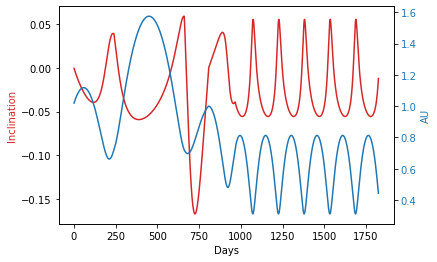

In [14]:
# Plot inclination and distance
inclinations = []
for i in timeframe:
    epoch = pop.champion_x[0]+i
    pos, _ = solar_orbiter.eph(pop.champion_x, epoch)
    inclination = sign(pos[2])*acos(norm(pos[:2]) / norm(pos))
    inclinations.append(inclination)

color = 'tab:red'
fig2, ax2 = plt.subplots()
ax2.plot(list(timeframe), inclinations, color=color)
ax2.set_ylabel("Inclination", color=color)
ax2.set_xlabel("Days")
ax.set_title("Distance and Inclination")

ax3 = ax2.twinx()  # instantiate a second axes that shares the same x-axis

color = 'tab:blue'
ax3.set_ylabel('AU', color=color)
ax3.plot(list(timeframe), distances, color=color)
ax3.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()